Onur Ordulu - Ezgi Taş - Asu Naz Yıldırım 

## Project
# 1. Introduction
# 1.1. Problem Description
The aim of this project is to develop a live betting strategy for soccer matches. Due to the dynamic nature of the game, decisions must be made based on real-time match data, which reflects the continuously shifting probabilities of outcomes as the game progresses. A key challenge is to select the optimal moment during the match to make a prediction, balancing the trade-off between information availability and decision timing. At this chosen time, the decision will be to either place a bet (selecting a home win, draw, or away win) or take no action based on the prediction. Therefore, the project mirrors a real-life scenario where the proposed strategy is limited to making a single decision at a specific moment in the match. Once the decision is made, no future information can be used to change it. The proposed strategy is assessed based on two key performance metrics: accuracy and return. Accuracy represents the proportion of matches where the prediction aligns with the final outcome, reflecting the model’s predictive reliability. Return measures the cumulative profitability of the strategy, calculated by betting one unit per match across the dataset. Together, these metrics provide a comprehensive evaluation of the strategy's effectiveness in predicting outcomes and generating consistent returns under realistic betting constraints.
# 1.2. Summary of the Proposed Approach
In order to achieve the aim of developing a model that maximizes revenue through live betting, two different tools are utilized: XGboost and random forest. Bookmaker odds were decided to be the most useful features since they reflect bookmaker’s approach to in-game statistics in addition to very crucial out-of-game information (market value of teams, etc.). Random forest model contains only bookmaker odds whereas XGboost model also contains various in-game statistics features that are determined based on both literature reviews and previous analysis on the same dataset (HW 2) such as Shots on Target, Saves, Shots Total, etc. When deciding if it is worth betting, the idea is to calculate expected values (EVs) of all possible bets at every minute. Predicted probability of end-game result is calculated based on each developed model at each minute dynamically (at every minute), and expected value of placing a bet is computed through these predicted probabilities and bookmaker odds at those instances. A threshold value for these calculated EVs is determined through a separate random forest model using the training data and the same threshold value is assumed to be applicable to test data as well. Once EV value of a bet exceeds the threshold value determined, our algorithm decides it is worth placing a bet and does not make further assessments for that same game, as asked in the project guide.
# 1.3. Descriptive Analysis of the Given Data
The dataset provided contains detailed match-related statistics, including unique match identifiers (fixture_id), timestamps for events (minute and second), and whether the event occurred in the first or second half (halftime). It also includes pre-match and in-play betting odds (1, X, 2) representing the probabilities for home win, draw, and away win outcomes, respectively. Match performance metrics such as shots on target, possession percentages, and fouls for both home and away teams are included, along with event-specific data like goals and red cards. Some key features of the data are provided in the below cells.

In [45]:
library(xgboost)
library(data.table)
library(Matrix)
library(rpart)
library(dplyr)
library(randomForest)
library(caret)

In [47]:
data_path='C:/Users/asuna/OneDrive/Belgeler/match_data.csv'
match_data <- fread(data_path)

In [49]:
# Summary of the dataset
summary(match_data)

   fixture_id         halftime          current_time                   
 Min.   :19134453   Length:63944       Min.   :2024-08-09 18:11:36.00  
 1st Qu.:19135301   Class :character   1st Qu.:2024-09-01 16:41:41.00  
 Median :19139737   Mode  :character   Median :2024-09-28 16:38:41.00  
 Mean   :19148005                      Mean   :2024-09-29 16:21:24.78  
 3rd Qu.:19155126                      3rd Qu.:2024-10-26 14:44:19.00  
 Max.   :19172117                      Max.   :2024-11-10 21:57:41.00  
                                                                       
 half_start_datetime             match_start_datetime            
 Min.   :2024-08-09 18:01:37.0   Min.   :2024-08-09 18:01:37.00  
 1st Qu.:2024-09-01 16:05:58.0   1st Qu.:2024-09-01 15:30:07.00  
 Median :2024-09-28 16:04:35.0   Median :2024-09-28 16:00:55.00  
 Mean   :2024-09-29 15:55:28.5   Mean   :2024-09-29 15:22:04.30  
 3rd Qu.:2024-10-26 14:11:14.0   3rd Qu.:2024-10-26 13:33:01.00  
 Max.   :2024-11-10 21:06:59

Upon exploring the dataset, the structure reveals both numerical variables (e.g., odds, shots, possession) and categorical variables (e.g., halftime, result). The dataset shows some missing values, particularly in in-play statistics and event-related columns, which may require further preprocessing. A summary of the data distributions highlights that most home teams tend to have fewer than 10 shots on target, with a small number exceeding this range. Possession percentages are evenly distributed, with a slight average advantage for home teams. The odds for home wins (1) tend to cluster between 1.5 and 3.0, reflecting a general market bias toward home team success. Correlation analysis reveals that odds for different outcomes are strongly related, consistent with efficient market behavior. Interestingly, possession shows only a weak correlation with odds, suggesting that betting odds incorporate more than just performance metrics.

In [52]:
# Check for missing values
colSums(is.na(match_data))

fixture_id                            halftime 
                                  0                                   0 
                       current_time                 half_start_datetime 
                                  0                                   0 
               match_start_datetime                              minute 
                                  0                                   0 
                             second             latest_bookmaker_update 
                                  0                                   0 
                          suspended                             stopped 
                                  0                                   0 
                                  1                                   2 
                                  0                                   0 
                                  X                                name 
                                  0                                   0 
                            ticking             Accurate Crosses - away 
                                  0                                3028 
            Accurate Crosses - home                      Assists - away 
                               3007                               27934 
                     Assists - home                      Attacks - away 
                              27931                                  39 
                     Attacks - home            Ball Possession % - away 
                                 33                                  23 
           Ball Possession % - home                    Ball Safe - away 
                                 22                               23428 
                   Ball Safe - home                   Challenges - away 
                              23424                                4681 
                  Challenges - home                      Corners - away 
                               4674                                  74 
                     Corners - home              Counter Attacks - away 
                                 66                               41211 
             Counter Attacks - home            Dangerous Attacks - away 
                              41209                                  53 
           Dangerous Attacks - home             Dribble Attempts - away 
                                 47                                7869 
            Dribble Attempts - home                        Fouls - away 
                               7844                                1627 
                       Fouls - home                   Free Kicks - away 
                               1615                               58465 
                  Free Kicks - home                Goal Attempts - away 
                              58465                               27536 
               Goal Attempts - home                   Goal Kicks - away 
                              27529                                4685 
                  Goal Kicks - home                        Goals - away 
                               4678                                  39 
                       Goals - home                      Headers - away 
                                 36                               10413 
                     Headers - home                 Hit Woodwork - away 
                              10406                                 198 
                Hit Woodwork - home                     Injuries - away 
                                177                               46318 
                    Injuries - home                Interceptions - away 
                              46316                                4255 
               Interceptions - home                   Key Passes - away 
                               4234                                5517 
                  Key Passes - home                  Long Passes - away 
          

Key patterns emerge when analyzing odds and match statistics over time. Odds fluctuate significantly during matches, particularly after key events like goals or red cards. Home win odds (1) typically decrease if the home team scores early, while draw odds (X) spike after events such as red cards. Temporal trends in match statistics show that teams attempt more shots in the second half compared to the first, while possession shows higher variance during the latter stages of matches, possibly due to tactical adjustments or fatigue. The impact of key events on odds is particularly striking, with goals causing sharp drops in odds for the scoring team and red cards leading to a substantial increase in odds for the penalized team. These findings emphasize the dynamic nature of both match statistics and odds throughout a match.\
Visualizations further support these observations. For example, the distribution of shots on target shows that most teams remain within 0-10 attempts, with possession remaining relatively stable in the first half but fluctuating significantly in the second. Odds for home wins decline steadily for successful home teams, reflecting the betting market's dynamic reassessment of probabilities as the match progresses. Goals and red cards are shown to have a profound impact on odds, highlighting their importance in predicting match outcomes.

Warning message:
"Removed 28 rows containing non-finite outside the scale range (`stat_bin()`)."


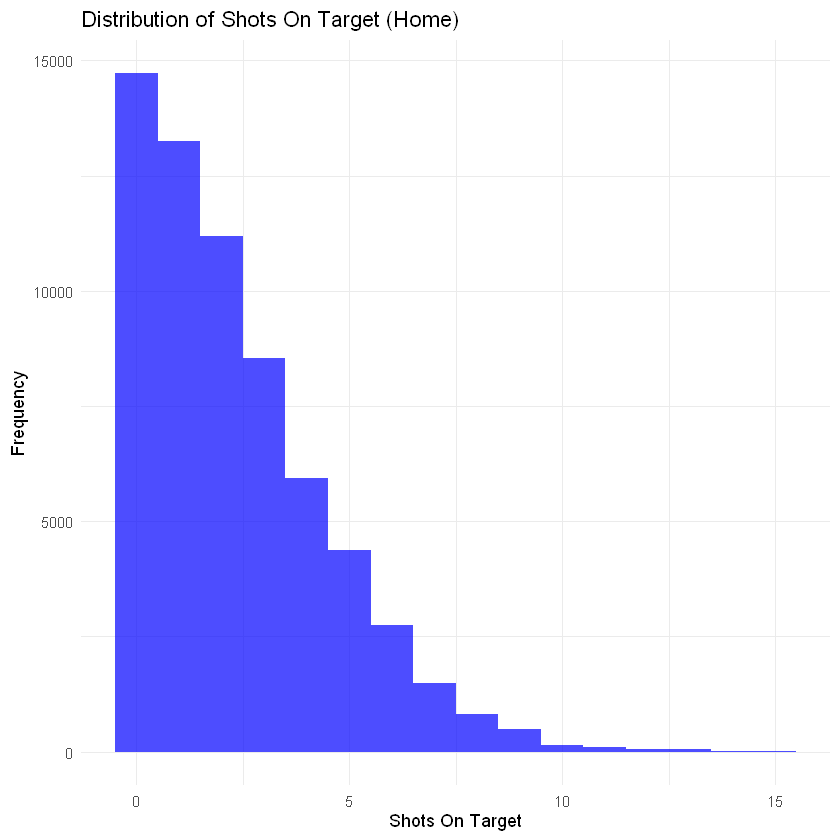

In [55]:
# Distribution of shots on target
ggplot(match_data, aes(x = `Shots On Target - home`)) +
  geom_histogram(binwidth = 1, fill = "blue", alpha = 0.7) +
  ggtitle("Distribution of Shots On Target (Home)") +
  xlab("Shots On Target") +
  ylab("Frequency") +
  theme_minimal()

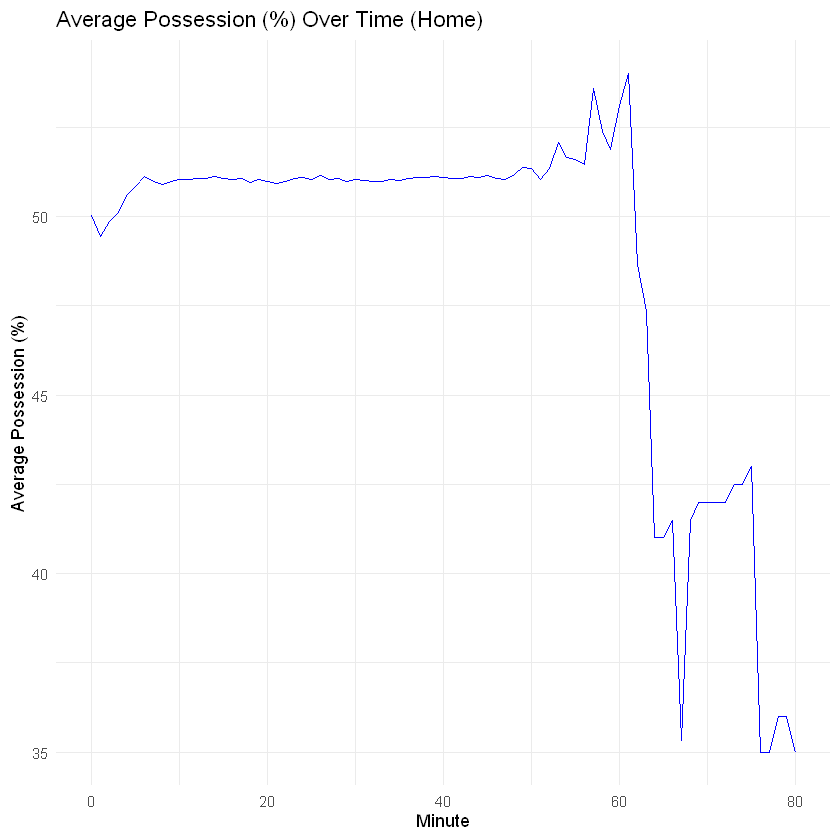

In [20]:
match_data %>%
  group_by(minute) %>%
  summarise(avg_possession_home = mean(`Ball Possession % - home`, na.rm = TRUE)) %>%
  ggplot(aes(x = minute, y = avg_possession_home)) +
  geom_line(color = "blue") +
  ggtitle("Average Possession (%) Over Time (Home)") +
  xlab("Minute") +
  ylab("Average Possession (%)") +
  theme_minimal()

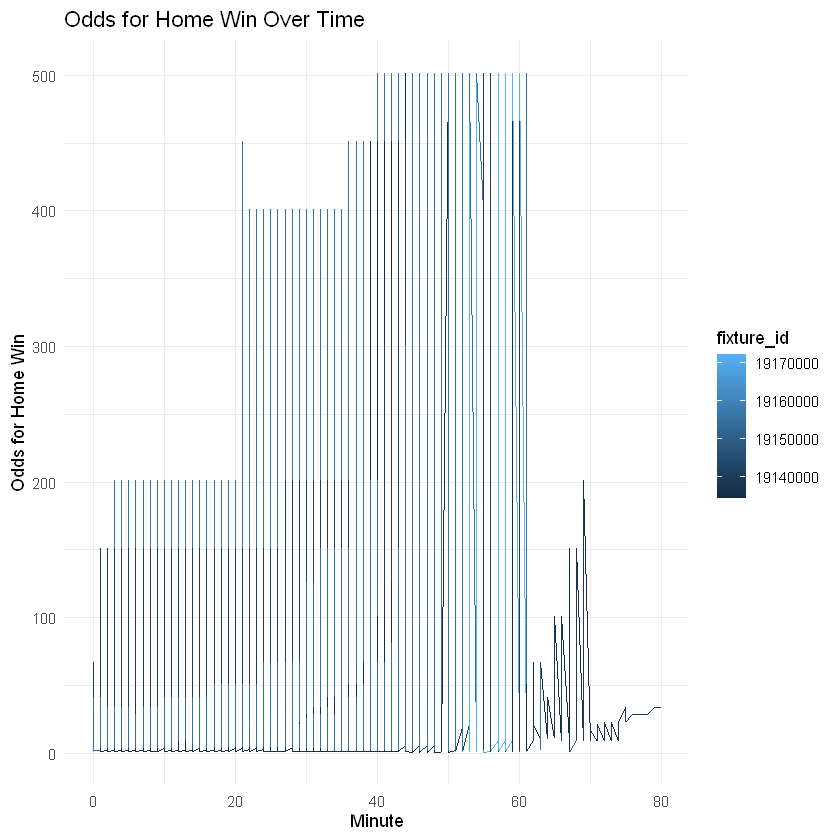

In [22]:
# Visualize odds over time
match_data %>%
  ggplot(aes(x = minute, y = `1`, color = fixture_id)) +
  geom_line() +
  ggtitle("Odds for Home Win Over Time") +
  xlab("Minute") +
  ylab("Odds for Home Win") +
  theme_minimal()

In conclusion, the dataset offers valuable insights into the behavior of odds and match dynamics. To enhance the analysis, features derived from event timestamps, cumulative trends, and dynamic match phases can be included. Addressing missing values and ensuring consistent preprocessing will further improve model performance. Additionally, optimizing expected value (EV) thresholds based on match phases can help improve profitability rather than just accuracy. These steps will provide a robust foundation for advanced predictive modeling and decision-making strategies.

## 2. Related Literature
In recent years, machine learning techniques have significantly advanced the field of sports betting, particularly in predicting soccer match outcomes. Decision trees and ensemble methods like XGBoost have been at the forefront of these developments.\
Terawong and Cliff (2024) introduced an innovative approach by integrating XGBoost within the Bristol Betting Exchange (BBE), an agent-based model simulating a sports-betting exchange. Their study demonstrated that XGBoost could learn profitable dynamic betting strategies by analyzing the actions of successful bettor agents, resulting in decision trees that outperformed the original strategies. \
Mills et al. (2024) developed a framework for soccer game prediction using advanced machine learning techniques, including XGBoost. Their methodology incorporated real-time features such as half-time results and goals, enhancing in-game decision-making. The study reported that models like XGBoost and Random Forests achieved high accuracy in predicting match outcomes across multiple leagues. \
Another study applied decision tree algorithms, including C5.0, Random Forest, and XGBoost, to predict English Premier League match outcomes. The research highlighted that ensemble methods, particularly XGBoost, improved prediction accuracy by effectively handling complex interactions between features. \
These studies underscore the efficacy of decision trees and XGBoost in modeling and predicting soccer match outcomes, providing a robust foundation for developing live betting strategies based on real-time data analysis.

# 3. Approach
## 3.1. Data Preprocessing
In machine learning, data needs to be in a proper and well-structured format to achieve optimal model performance. Therefore, data preprocessing, which can be defined as transforming raw data into a clean and organized dataset suitable for analysis and modeling, is an important step. 
As a first step, the rows where “suspended” values are true or “stopped” values are true are removed. The "stopped" condition means that odds are completely stopped, while the "suspended" status means that odds are momentarily unavailable because of the events such as goals, penalties, fouls, or bookmaker modifications. In these circumstances, odds are unreliable and should be ignored in order to avoid adding misleading information into the model.
## 3.1.1. Feature Selection
According to literature, there are several other important factors that affect the result of a match such as difference in total market value of competing sides (Bai et al., 2023), recent form of the competing sides, injured players at the time of the match, etc. These features that are not in-game statistics are absent in our dataset, but they are considered in bookmaker’s betting odds. That is why bookmaker odds (columns 1, 2 and X) are added in trained models and arguably, they are the features with the most information.
Topic of live betting based on in-game statistics is well-studied application of machine learning and data mining. Bai et al. (2023) reviews the situation of in-game statistics relevance to match results in three major leagues and discussed important features through different machine learning models. The feature selection that is performed in this work is a combination of our own analysis of given match data and work conducted in literature that discuss feature importance. Previous analysis carried out in the same dataset (in HW2) concluded Shots on Target, Saves, Shots Total, Key Passes, Shots Insidebox, Goal Attempts and Dangerous Attacks features are of importance in deciding the game results. These features, although important, contain many NA values in the given dataset which make it difficult to use them in our live betting model construction application. Since boosting is a method that can take care of NA values through its surrogate splits, both home and away features of the above in-game statistics are added in the XGboost model. Although Redcards features for home and away were not found important in data analysis, Redcards for home and away were included in this study since it has a strong impact on the game and it is a studied feature in literature, for similar applications (Bai et al., 2023). However, since the implementation in R does not accept missing values for the random forest, only the odds are used to train this model.
## 3.1.2. Train-Test Split
The data is splitted into training and testing sets according to the match date. Matches before 1 November  2024, are used for training, while matches on or after this date for testing.
## 3.2. Model Development
## 3.2.1. Probability Prediction Model
This model is trained to predict the probability of each possible match outcome (home win, draw, or away win) by using historical match data (train data). The class probabilities obtained from the model are used for evaluating the expected value (EV) of potential bets.\
Two distinct models ( random forest and boosting) are developed for probability prediction. Boosting and random forests are both ensemble methods that use decision trees, but they differ significantly in how the trees are built and combined:\
\
**Random Forest:** \
Random Forest is an ensemble learning method which creates multiple decision trees during training.  A random sample of the data is used to train each tree and a random subset of features are taken into account for splitting. In prediction, it returns either the mode of the classes (for classification) or the mean prediction (for regression) of individual trees. By combining the results of multiple deep decision trees trained on various subsets of the dataset, it minimizes the risk of overfitting. There are key parameters in the model, which can be tuned:
- ntree = 200 : sets number of trees in the forest
- mtry = 3 : specifies the number of features randomly sampled as candidates at each split
- The default value for the minimum size of terminal nodes (nodesize) in classification is 1

The implementation in R also provides the matrix of class probabilities, which corresponds to one column for  each class and one row for each input.

**Boosting:** \
Boosting is an ensemble learning technique that combines multiple weak learners (typically decision trees) to create a strong predictive model. Unlike other ensemble methods like bagging, boosting builds models sequentially, where each subsequent model focuses on correcting the errors made by its predecessors. This iterative process helps the overall model improve its performance by gradually reducing bias and variance. In boosting, the weak learners are trained on weighted versions of the dataset, where more weight is given to the samples that were misclassified in previous iterations. The final prediction is made by aggregating the outputs of all weak learners.
XGBoost builds upon the gradient boosting framework, which is a powerful machine learning technique. Unlike traditional gradient boosting implementations, XGBoost optimizes computational performance using techniques like parallel processing, tree pruning, and efficient memory management. It also integrates regularization (L1 and L2) to prevent overfitting, which is not standard in traditional gradient boosting frameworks.

In this work, parameters of XGboost algorithm are set in a way that best serves our aim presented in Problem Description. The tuned settings are as follows:

- objective = "multi:softprob": Specifies a multiclass classification problem where the model outputs class probabilities.
- num_class = 3: Indicates there are 3 classes to predict (Home Win, Draw, Away Win).
- eval_metric = "mlogloss": Uses multiclass logarithmic loss to evaluate model performance during training.
- subsample = 0.8: Randomly samples 80% of the training data for each boosting round to prevent overfitting.
- colsample_bytree = 0.8: Samples 80% of features for each tree, improving generalization.
- colsample_bylevel = 0.8: Samples 80% of features at each level of the tree, further reducing overfitting.
- max_depth = 8: Sets the maximum depth of trees to allow for deeper, more complex trees.
- min_child_weight = 0.1: Sets the minimum sum of instance weights needed in a child node, influencing model sensitivity to small groups.
- lambda = 1: L2 regularization term to prevent overfitting by penalizing large weights.
- eta = 0.5: The learning rate, which controls the contribution of each tree to the final prediction; a higher value means larger updates and faster convergence.
 
While deciding on the parameter values a balance between overfitting prevention and accurate prediction was tried to be maintained.
The models can be compared as follows:
**<div style="text-align:center"> 
Table 3.1 Model Comparison**

| *Aspect*               | *Random Forest*                                    | *Boosting*                                      |
|--------------------------|------------------------------------------------------|--------------------------------------------------|
| *Tree Building Process* | Trees are built independently of each other, using different subsets of data and features (bagging). Each tree is a fully grown decision tree. | Trees are built sequentially, with each tree correcting the errors of the previous ones. |
| *Focus on Errors*       | Focuses on reducing variance by averaging predictions from many independent trees. | Focuses on reducing bias. |
| *Ensemble Combination*  | Combines trees using majority voting.                | Combines trees by weighting their contributions based on their performance. |
| *Performance*           | Often less prone to overfitting.                     | Higher accuracy but requires careful tuning to avoid overfitting. |

**Decision Making Strategy:** \
After the model outputs the class probabilities, the expected value (EV) for each bet is found to evaluate potential profitability.
$$
EV =P (odds-1) -(1-P)
$$
P is the predicted probability of the outcome. odds corresponds to odds set by the bookmaker for that outcome.
The outcome with the highest positive EV for betting is chosen as a betting decision. If all EVs are negative, the model selects "no action."  The aim is to balance risk and profit by ensuring that bets are only placed when they are favorable.
Since we are still in the training dataset, if the bet decision matches the match result, the accuracy for that match is recorded as 1. If the decision is no action, meaning the match result cannot be predicted, the accuracy is also considered as 0 for that match.

## 3.2.2. Optimal Decision-Making Model
After training the probability prediction model and making a decision, we now know how accurate our model is at the training phase. At this stage, another model is needed to determine the optimal time to place a bet during a match by capturing the relationship between the expected value of each betting option and time-related features. Given the expected value of each betting option and time-related features, the model aims to predict the probability of the accuracy of our decision, which is defined as probability of success. After obtaining the success probabilities, thresholds from 0 to 1 are tested to select an optimum value that maximizes prediction accuracy on the training data set. Only probabilities that exceed this chosen threshold are considered strong enough to make a decision. The aim is to ensure that only high-confidence predictions cause betting actions by considering time-related features. Random forest is trained to detect the optimal decision time.

## 3.2.3. Evaluation Metrics
The strategy is evaluated based on two key performance metrics: accuracy and return. Accuracy represents the proportion of matches where the prediction and the final outcome matches at the test data. Return is the cumulative profitability of the strategy, which is found by betting one unit per match across the test data. 




In [57]:
match_data <- match_data %>%
  filter(suspended != "TRUE" & stopped != "TRUE")
# Ensure halftime data is considered when ordering
match_data <- match_data %>%
  mutate(half_time_order = ifelse(halftime == "1st-half", 1, 2)) %>%
  arrange(fixture_id, half_time_order, minute, second)

# Define train-test split based on match date
match_data <- match_data %>% mutate(match_date = as.Date(match_start_datetime))
match_data <- match_data %>%
  mutate(time_in_match = ifelse(halftime == "1st-half", minute + second / 60,
                                45 + minute + second / 60))
train_data <- match_data %>% filter(match_date < as.Date("2024-11-01"))
test_data <- match_data %>% filter(match_date >= as.Date("2024-11-01"))

In [59]:
# Define features (X) and target (y)
X_train <- train_data %>%
  select(
    `1`, `2`, `X`
  ) %>%
  as.matrix()
y_train <- train_data$result

X_test <- test_data %>%
  select(
    `1`, `2`, `X`
  ) %>%
  as.matrix()
y_test <- test_data$result

set.seed(1234)  # Set the seed
# Replace 'X' with 0
y_train[y_train == "X"] <- 0
y_test[y_test == "X"] <- 0
model <- randomForest(
  x = as.data.frame(X_train),
  y = as.factor(y_train),
  ntree = 200,      # Number of trees
  mtry = 3,         # Number of features considered at each split
  importance = TRUE
)
# Predict probabilities on train data
pred_probs_train <- predict(model, newdata = as.data.frame(X_train), type = "prob")

In [63]:
train_data <- train_data %>%
  mutate(
    P_home = pred_probs_train[, "1"], 
    P_draw = pred_probs_train[, "0"],
    P_away = pred_probs_train[, "2"],
    
    ev_home = pred_probs_train[, "1"] * (`1` - 1) - (1 - pred_probs_train[, "1"]),
    ev_draw = pred_probs_train[, "0"] * (`X` - 1) - (1 - pred_probs_train[, "0"]),
    ev_away = pred_probs_train[, "2"] * (`2` - 1) - (1 - pred_probs_train[, "2"]),
    
    decision = case_when(
      ev_home > ev_draw & ev_home > ev_away & ev_home > 0 ~ "bet_home",
      ev_draw > ev_home & ev_draw > ev_away & ev_draw > 0 ~ "bet_draw",
      ev_away > ev_home & ev_away > ev_draw & ev_away > 0 ~ "bet_away",
      TRUE ~ "no_action"),
    
    prediction = case_when(
      decision == "bet_home" ~ "1",
      decision == "bet_away" ~ "2",
      decision == "bet_draw" ~ "X",
      decision == "no_action" ~ "0",
      TRUE ~ NA  # Optional: Handle unexpected values with NA
    ),
    
    accuracy = ifelse(prediction == as.character(result), 1, 0),
    
    return = case_when(
      # If accuracy is 1, take the odd of the prediction
      accuracy == 1 & prediction == "1" ~ as.numeric(`1`),
      accuracy == 1 & prediction == "2" ~ as.numeric(`2`),
      accuracy == 1 & prediction == "X" ~ as.numeric(`X`),
      
      # If accuracy is 0 and prediction is 0, return 0
      accuracy == 0 & prediction == "0" ~ 0,
      
      # If accuracy is 0 and prediction is 1, 2, or X, return 0
      accuracy == 0 & prediction %in% c("1", "2", "X") ~ 0,
      
      # Default case (if none of the above conditions apply)
      TRUE ~ NA_real_
    )
  )


train_data_summary <- train_data[,c('fixture_id','halftime','minute','second','time_in_match','1','X','2','P_home','P_draw','P_away',
                                    'ev_home','ev_draw','ev_away','result','prediction','accuracy','return')]


In [65]:
# Train a Random Forest Model
rf_model <- randomForest(
  x = train_data_summary[, c("ev_home", "ev_draw", "ev_away", "time_in_match",'halftime','minute','second')],  # Features
  y = as.factor(train_data_summary$accuracy),  # Target (convert to factor)
  ntree = 100,  # Number of trees
  mtry = 2,     # Number of features to consider at each split
  importance = TRUE
)
# Find the Optimal Threshold Based on Training Data
thresholds <- seq(0, 1, by = 0.01)

# Calculate accuracy for each threshold on the training data
train_rf_probs <- predict(rf_model, newdata = train_data_summary[, c("ev_home", "ev_draw", "ev_away","time_in_match",'halftime','minute','second')], type = "prob")
train_data_summary$success_prob <- train_rf_probs[, 2]  # Probability for success (class 1)

accuracies <- sapply(thresholds, function(threshold) {
  predicted <- ifelse(train_data_summary$success_prob >= threshold, 1, 0)
  mean(predicted == train_data_summary$accuracy)
})

optimal_threshold <- thresholds[which.max(accuracies)]
print(paste("Final Accuracy on Training Data:", max(accuracies)))
print(paste("Optimal Threshold from Training Data:", optimal_threshold))

[1] "Final Accuracy on Training Data: 0.987016914735046"
[1] "Optimal Threshold from Training Data: 0.65"


In [67]:
pred_probs_test <- predict(model, newdata = as.data.frame(X_test), type = "prob")

test_data <- test_data %>%
  mutate(
    P_home = pred_probs_test[, "1"],
    P_draw = pred_probs_test[, "0"],
    P_away = pred_probs_test[, "2"],
    
    ev_home = pred_probs_test[, "1"] * (`1` - 1) - (1 - pred_probs_test[, "1"]),
    ev_draw = pred_probs_test[, "0"] * (`X` - 1) - (1 - pred_probs_test[, "0"]),
    ev_away = pred_probs_test[, "2"] * (`2` - 1) - (1 - pred_probs_test[, "2"]),
    
    decision = case_when(
      ev_home > ev_draw & ev_home > ev_away & ev_home > 0 ~ "bet_home",
      ev_draw > ev_home & ev_draw > ev_away & ev_draw > 0 ~ "bet_draw",
      ev_away > ev_home & ev_away > ev_draw & ev_away > 0 ~ "bet_away",
      TRUE ~ "no_action"),
    
    prediction = case_when(
      decision == "bet_home" ~ "1",
      decision == "bet_away" ~ "2",
      decision == "bet_draw" ~ "X",
      decision == "no_action" ~ "0",
      TRUE ~ NA  # Optional: Handle unexpected values with NA
    ),
    
    accuracy = ifelse(prediction == as.character(result), 1, 0),
    
    return = case_when(
      # If accuracy is 1, take the odd of the prediction
      accuracy == 1 & prediction == "1" ~ as.numeric(`1`),
      accuracy == 1 & prediction == "2" ~ as.numeric(`2`),
      accuracy == 1 & prediction == "X" ~ as.numeric(`X`),
      
      # If accuracy is 0 and prediction is 0, return 0
      accuracy == 0 & prediction == "0" ~ 0,
      
      # If accuracy is 0 and prediction is 1, 2, or X, return 0
      accuracy == 0 & prediction %in% c("1", "2", "X") ~ 0,
      
      # Default case (if none of the above conditions apply)
      TRUE ~ NA_real_
    )
  )

test_data_summary <- test_data[,c('fixture_id','halftime','minute','second','time_in_match','1','X','2','P_home','P_draw','P_away',
                                  'ev_home','ev_draw','ev_away','result','prediction','accuracy','return')]

# Predict probabilities on test data
rf_probs <- predict(rf_model, newdata = test_data_summary[, c("ev_home", "ev_draw", "ev_away", "time_in_match",'halftime','minute','second')], type = "prob")
test_data_summary$success_prob <- rf_probs[, 2]  # Probability for success (class 1)

# Apply the Optimal Threshold to Classify Test Data
test_data_summary <- test_data_summary %>%
  mutate(predicted_success = ifelse(success_prob >= optimal_threshold, 1, 0))

# Add decision_time column
test_data_summary <- test_data_summary %>%
  mutate(
    decision_time = ifelse(predicted_success == 1, TRUE, FALSE),
  )

# Extract the first decision time for each match
decision_points <- test_data_summary %>%
  filter(decision_time == TRUE) %>%  # Filter rows where decision_time is TRUE
  group_by(fixture_id) %>%          # Group by match (fixture_id)
  slice_min(order_by = time_in_match, n = 1, with_ties = FALSE) %>%  # Find the earliest time
  select(fixture_id, halftime, minute, second,`1`,`X`,`2`, success_prob, time_in_match,result,prediction,
         accuracy,return)


In [35]:
decision_points

fixture_id,halftime,minute,second,1,X,2,success_prob,time_in_match,result,prediction,accuracy,return
<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
19134533,1st-half,9,31,2.75,3.40,2.50,0.67,9.5166667,1,2,0,0.00
19134534,1st-half,1,34,4.00,4.00,1.80,0.74,1.5666667,1,2,0,0.00
19134535,1st-half,1,28,2.87,3.40,2.50,0.81,1.4666667,X,2,0,0.00
19134536,1st-half,5,25,3.25,3.10,2.25,0.89,5.4166667,2,2,1,2.25
19134537,1st-half,1,5,1.50,4.75,6.00,0.80,1.0833333,1,X,0,0.00
19134538,1st-half,1,48,1.33,5.50,8.00,0.96,1.8000000,1,1,1,1.33
19134539,1st-half,2,3,2.75,3.25,2.60,0.88,2.0500000,2,1,0,0.00
19134540,1st-half,2,5,1.25,6.50,9.00,0.99,2.0833333,2,1,0,0.00
19134541,1st-half,6,50,2.20,3.20,3.40,0.89,6.8333333,X,X,1,3.20


In [69]:
# Count unique matches using fixture_id
total_num_matches_test <- length(unique(test_data_summary$fixture_id))
num_matches_bet <- length(unique(decision_points$fixture_id))
# Print the result
print(paste("Number of matches in test data:", total_num_matches_test))
print(paste("Number of matches that are bet/decided in test data:", num_matches_bet))


mean_accuracy = mean(decision_points$accuracy)
print(paste("Accuracy in test data:", mean_accuracy))
sum_return <- sum(decision_points$return)
print(paste("Return for decided matches in test data:", sum_return))


[1] "Number of matches in test data: 111"
[1] "Number of matches that are bet/decided in test data: 111"
[1] "Accuracy in test data: 0.531531531531532"
[1] "Return for decided matches in test data: 126.09"


In [71]:
set.seed(1234)  # Set the seed
# Define features (X) and target (y)
X_train <- train_data %>%
  select(
    `1`, `2`, `X`, `minute`, `second`,`time_in_match`,
    `Shots On Target - home`, `Shots On Target - away`,
    `Saves - away`, `Saves - home`, `Goal Attempts - home`, `Goal Attempts - away`,
    `Shots Total - home`, `Shots Total - away`, `Dangerous Attacks - home`,
    `Dangerous Attacks - away`, `Shots Insidebox - home`, `Shots Insidebox - away`,
    `Redcards - away`, `Redcards - home`, `Key Passes - away`, `Key Passes - home`
  ) %>%
  as.matrix()
y_train <- train_data$result

X_test <- test_data %>%
  select(
    `1`, `2`, `X`, `minute`, `second`,`time_in_match`,
    `Shots On Target - home`, `Shots On Target - away`,
    `Saves - away`, `Saves - home`, `Goal Attempts - home`, `Goal Attempts - away`,
    `Shots Total - home`, `Shots Total - away`, `Dangerous Attacks - home`,
    `Dangerous Attacks - away`, `Shots Insidebox - home`, `Shots Insidebox - away`,
    `Redcards - away`, `Redcards - home`, `Key Passes - away`, `Key Passes - home`
  ) %>%
  as.matrix()
y_test <- test_data$result

# Replace 'X' with 0
y_train[y_train == "X"] <- 0
y_test[y_test == "X"] <- 0

# Convert y_train to numeric (if necessary, e.g., if it's a factor or character vector)
y_train <- as.numeric(as.character(y_train))
y_test <- as.numeric(as.character(y_test))


# Create XGBoost DMatrices for training and testing
dtrain <- xgb.DMatrix(data = X_train, label = y_train)
dtest <- xgb.DMatrix(data = X_test, label = y_test)


#Training
# Define XGBoost parameters
params <- list(
  objective = "multi:softprob",  # Multiclass classification with probabilities
  num_class = 3,                # Number of classes (1: Home Win, 0: Draw, 2: Away Win)
  eval_metric = "mlogloss",
  subsample = 0.8,
  colsample_bytree = 0.8,       # Feature subsampling per tree (80% of columns)
  colsample_bylevel = 0.8,      # Feature subsampling per level (80% of columns per level)
  max_depth = 8,  # Allow deeper trees
  min_child_weight = 0.1,  # More sensitivity to smaller groups
  lambda = 1,                   # L2 regularization
  eta = 0.5                     # Learning rate
)

# Create the group variable (fixture_id) from the original training data
groups <- train_data$fixture_id

# Ensure that groups match the rows of the DMatrix
if (length(groups) != nrow(X_train)) {
  stop("Mismatch between group length and training data rows")
}

# Run cross-validation with grouping
xgb_cv <- xgb.cv(
  params = params,
  data = dtrain,
  nfold = 5,
  nrounds = 300,
  early_stopping_rounds = 10,
  verbose = 0,
  folds = createFolds(groups, k = 5)  # Create grouped folds
)

# Extract the best number of rounds (iterations)
best_nrounds <- xgb_cv$best_iteration

# Train the final model using the best number of rounds
model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = best_nrounds,
  verbose = 1
)

# Predict probabilities on train data
pred_probs_train <- predict(model, newdata = dtrain)
pred_probs_train <- matrix(pred_probs_train, ncol = 3, byrow = TRUE)  # Reshape into a probability matrix

In [73]:
train_data <- train_data %>%
  mutate(
    P_home = pred_probs_train[, 2],
    P_draw = pred_probs_train[, 1],
    P_away = pred_probs_train[, 3],
    
    ev_home = pred_probs_train[, 2] * (`1` - 1) - (1 - pred_probs_train[, 2]),
    ev_draw = pred_probs_train[, 1] * (`X` - 1) - (1 - pred_probs_train[, 1]),
    ev_away = pred_probs_train[, 3] * (`2` - 1) - (1 - pred_probs_train[, 3]),
    
    decision = case_when(
      ev_home > ev_draw & ev_home > ev_away & ev_home > 0 ~ "bet_home",
      ev_draw > ev_home & ev_draw > ev_away & ev_draw > 0 ~ "bet_draw",
      ev_away > ev_home & ev_away > ev_draw & ev_away > 0 ~ "bet_away",
      TRUE ~ "no_action"),
    
    prediction = case_when(
      decision == "bet_home" ~ "1",
      decision == "bet_away" ~ "2",
      decision == "bet_draw" ~ "X",
      decision == "no_action" ~ "0",
      TRUE ~ NA  # Optional: Handle unexpected values with NA
      ),
      
      accuracy = ifelse(prediction == as.character(result), 1, 0),
      
      return = case_when(
        # If accuracy is 1, take the odd of the prediction
        accuracy == 1 & prediction == "1" ~ as.numeric(`1`),
        accuracy == 1 & prediction == "2" ~ as.numeric(`2`),
        accuracy == 1 & prediction == "X" ~ as.numeric(`X`),
        
        # If accuracy is 0 and prediction is 0, return 0
        accuracy == 0 & prediction == "0" ~ 0,
        
        # If accuracy is 0 and prediction is 1, 2, or X, return 0
        accuracy == 0 & prediction %in% c("1", "2", "X") ~ 0,
        
        # Default case (if none of the above conditions apply)
        TRUE ~ NA_real_
      )
  )

    
train_data_summary <- train_data[,c('fixture_id','halftime','minute','second','time_in_match','1','X','2','P_home','P_draw','P_away',
                                        'ev_home','ev_draw','ev_away','result','prediction','accuracy','return')]

In [75]:
# Train a Random Forest Model
rf_model <- randomForest(
  x = train_data_summary[, c("ev_home", "ev_draw", "ev_away", "time_in_match",'halftime','minute','second')],  # Features
  y = as.factor(train_data_summary$accuracy),  # Target (convert to factor)
  ntree = 100,  # Number of trees
  mtry = 2,     # Number of features to consider at each split
  importance = TRUE
)

# Find the Optimal Threshold Based on Training Data
thresholds <- seq(0, 1, by = 0.01)

# Calculate accuracy for each threshold on the training data
train_rf_probs <- predict(rf_model, newdata = train_data_summary[, c("ev_home", "ev_draw", "ev_away","time_in_match",'halftime','minute','second')], type = "prob")
train_data_summary$success_prob <- train_rf_probs[, 2]  # Probability for success (class 1)

accuracies <- sapply(thresholds, function(threshold) {
  predicted <- ifelse(train_data_summary$success_prob >= threshold, 1, 0)
  mean(predicted == train_data_summary$accuracy)
})

optimal_threshold <- thresholds[which.max(accuracies)]
print(paste("Final Accuracy on Training Data:", max(accuracies)))
print(paste("Optimal Threshold from Training Data:", optimal_threshold))

[1] "Final Accuracy on Training Data: 1"
[1] "Optimal Threshold from Training Data: 0.38"


In [77]:
#Testing
# Predict probabilities on test data
pred_probs_test <- predict(model, newdata = dtest)
pred_probs_test <- matrix(pred_probs_test, ncol = 3, byrow = TRUE)  # Reshape into a probability matrix

test_data <- test_data %>%
  mutate(
    P_home = pred_probs_test[, 2],
    P_draw = pred_probs_test[, 1],
    P_away = pred_probs_test[, 3],
    
    ev_home = pred_probs_test[, 2] * (`1` - 1) - (1 - pred_probs_test[, 2]),
    ev_draw = pred_probs_test[, 1] * (`X` - 1) - (1 - pred_probs_test[, 1]),
    ev_away = pred_probs_test[, 3] * (`2` - 1) - (1 - pred_probs_test[, 3]),
    
    decision = case_when(
      ev_home > ev_draw & ev_home > ev_away & ev_home > 0 ~ "bet_home",
      ev_draw > ev_home & ev_draw > ev_away & ev_draw > 0 ~ "bet_draw",
      ev_away > ev_home & ev_away > ev_draw & ev_away > 0 ~ "bet_away",
      TRUE ~ "no_action"),
    
    prediction = case_when(
      decision == "bet_home" ~ "1",
      decision == "bet_away" ~ "2",
      decision == "bet_draw" ~ "X",
      decision == "no_action" ~ "0",
      TRUE ~ NA  # Optional: Handle unexpected values with NA
    ),
    
    accuracy = ifelse(prediction == as.character(result), 1, 0),
    
    return = case_when(
      # If accuracy is 1, take the odd of the prediction
      accuracy == 1 & prediction == "1" ~ as.numeric(`1`),
      accuracy == 1 & prediction == "2" ~ as.numeric(`2`),
      accuracy == 1 & prediction == "X" ~ as.numeric(`X`),
      
      # If accuracy is 0 and prediction is 0, return 0
      accuracy == 0 & prediction == "0" ~ 0,
      
      # If accuracy is 0 and prediction is 1, 2, or X, return 0
      accuracy == 0 & prediction %in% c("1", "2", "X") ~ 0,
      
      # Default case (if none of the above conditions apply)
      TRUE ~ NA_real_
    )
  )

test_data_summary <- test_data[,c('fixture_id','halftime','minute','second','time_in_match','1','X','2','P_home','P_draw','P_away',
                                    'ev_home','ev_draw','ev_away','result','prediction','accuracy','return')]

# Predict probabilities on test data
rf_probs <- predict(rf_model, newdata = test_data_summary[, c("ev_home", "ev_draw", "ev_away", "time_in_match",'halftime','minute','second')], type = "prob")
test_data_summary$success_prob <- rf_probs[, 2]  # Probability for success (class 1)

# Apply the Optimal Threshold to Classify Test Data
test_data_summary <- test_data_summary %>%
  mutate(predicted_success = ifelse(success_prob >= optimal_threshold, 1, 0))

# Add decision_time column
test_data_summary <- test_data_summary %>%
  mutate(
    decision_time = ifelse(predicted_success == 1, TRUE, FALSE),
  )

# Extract the first decision time for each match
decision_points <- test_data_summary %>%
  filter(decision_time == TRUE) %>%  # Filter rows where decision_time is TRUE
  group_by(fixture_id) %>%          # Group by match (fixture_id)
  slice_min(order_by = time_in_match, n = 1, with_ties = FALSE) %>%  # Find the earliest time
  select(fixture_id, halftime, minute, second,`1`,`X`,`2`, success_prob, time_in_match,result,prediction,
         accuracy,return)

In [79]:
decision_points

fixture_id,halftime,minute,second,1,X,2,success_prob,time_in_match,result,prediction,accuracy,return
<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
19134533,1st-half,2,32,2.60,3.50,2.62,1.00,2.5333333,1,X,0,0.00
19134534,1st-half,1,34,4.00,4.00,1.80,0.82,1.5666667,1,1,1,4.00
19134535,1st-half,1,28,2.87,3.40,2.50,0.98,1.4666667,X,2,0,0.00
19134536,1st-half,2,27,3.25,3.25,2.25,0.76,2.4500000,2,X,0,0.00
19134537,1st-half,1,5,1.50,4.75,6.00,0.85,1.0833333,1,1,1,1.50
19134538,1st-half,1,48,1.33,5.50,8.00,0.99,1.8000000,1,1,1,1.33
19134539,1st-half,2,3,2.75,3.25,2.60,1.00,2.0500000,2,1,0,0.00
19134540,1st-half,2,5,1.25,6.50,9.00,1.00,2.0833333,2,1,0,0.00
19134541,1st-half,1,52,2.10,3.25,3.50,0.83,1.8666667,X,1,0,0.00


In [81]:
# Count unique matches using fixture_id
total_num_matches_test <- length(unique(test_data_summary$fixture_id))
num_matches_bet <- length(unique(decision_points$fixture_id))
# Print the result
print(paste("Number of matches in test data:", total_num_matches_test))
print(paste("Number of matches that are bet/decided in test data:", num_matches_bet))


mean_accuracy = mean(decision_points$accuracy)
print(paste("Accuracy in test data:", mean_accuracy))
sum_return <- sum(decision_points$return)
print(paste("Return for decided matches in test data:", sum_return))


[1] "Number of matches in test data: 111"
[1] "Number of matches that are bet/decided in test data: 111"
[1] "Accuracy in test data: 0.378378378378378"
[1] "Return for decided matches in test data: 84.32"


In [83]:
# Extract the last observation for each fixture_id
test_data_last <- test_data %>%
  group_by(fixture_id) %>%  # Group by fixture_id
  slice_tail(n = 1) %>%     # Select the last row of each group
  ungroup()                 # Ungroup to return a regular data frame

test_data_last <- test_data_last %>%
  mutate(prediction = current_state,
         accuracy = ifelse(prediction == result, 1, 0),
         return = accuracy * case_when(
           prediction == 1 ~ `1`,  # Use value in column '1' if prediction is 1
           prediction == 2 ~ `2`,  # Use value in column '2' if prediction is 2
           prediction == "X" ~ `X` # Use value in column 'X' if prediction is "X"
         )
         )

test_data_last_summary <- test_data_last[,c('fixture_id','halftime','minute','second',
                                    'time_in_match','1','X','2','result',
                                    'prediction','accuracy','return')]

# Calculate the sum of the return column
total_return <- sum(test_data_last$return, na.rm = TRUE)

# Print the result
print(total_return)

bet_accuracy<-sum(test_data_last$accuracy)/nrow(test_data_last)

# Print the result
print(bet_accuracy)

[1] 108.65
[1] 0.963964


## 4. Results
In addition to XGboost and random forest models that were trained, an additional simple betting decision algorithm of betting the safest bet at the last available minute is also studied. The expectation for this last trial was to observe high accuracy with very low returns at each bet. The results are given in Table 4.1.
**<div style="text-align:center"> 
Table 4.1. Accuracy and Return Values of Last_Minute_Betting, XGboost and Random Forest Models**

| *Model*             | *Accuracy* | *Return* |
|-----------------------|--------------|------------|
| Last_Minute_Betting   | 0.9640       | 108.65     |
| XGboost               | 0.3784       | 84.32      |
| Random Forest         | 0.5315       | 126.09     |

It should be noted that accuracy and return values in Table 4.1 are calculated from the test dataset. It was made sure that only a single bet is made for 111 matches that are present in the test set only with the information available until the betting time for every match (information later than the betting minute is not used by the algorithm).\
As can be seen from Table 4.1, high accuracy and high profit are two separate things in betting. Betting for the current state of a game at the very last minute is the most straightforward approach to making profits through live betting. This highly conservative approach focuses on accuracy too much but the problem is that bookmaker’s continuously place and modify their odds in order to make sure they do not lose as a result of this very predictable betting strategy. The return column in Table 4.1 is calculated as a result of 111 bets placed on 111 matches (one bet per match in the training set) assuming each bet is of unit magnitude. This implies although very accurate, last minute betting strategy generates net loss equal to -2.35, which means on aggregate, bookmaker odds are so low at the time of bet placement that the risk of believing a match would end in its current state at the last recorded minute is still unjustified.\
XGboost is an algorithm that works even in the presence of NA values in a dataset which makes it very useful for the dataset at hand. Its most severe challenge is to avoid overfitting. Although tuning parameters are adjusted to try to avoid overfitting as shown in section 2.1, still XGboost model gives very high training accuracy while testing accuracy is poor which implies overfitting. Thus, a reliable XGboost model cannot be trained in the end.
Random forest model produced the most desirable betting performance. The model is able to predict more than half of match results correctly and results in net profit of magnitude 15.09. Net positive profit indicates that it is possible to train a model that predicts match results better than bookmakers using live in-game statistics and bookmaker odds. In other words, our model thinks that in some instances during a match, bookmakers underestimate probabilities of some outcomes and place odds that are higher than they should. Consequently, the algorithm sees an opportunity to make profits and places bets, and as a result in this application, makes money. Additionally, the random forest model makes predictions later in the game compared to the XGBoost algorithm. This might be the reason why the random forest algorithm gives more accurate results; it is prone to wait for a safer betting window rather than betting at the first opportunity.\
The dataset contains several features with a high percentage of missing (NA) values, which presents a significant challenge in machine learning applications. While missing data can often be addressed through imputation techniques, some features have so many NA values that they are unreliable and unsuitable for analysis. Furthermore, imputation can distort the relationship between these features and match outcomes, which can result in poorer model performance  despite attempts to reconstruct the data. We decided to concentrate on a subset of features with few missing values in order to solve this problem. Specifically, we relied on bookmaker odds to train random forest, as they were consistently available and directly relevant to match outcome predictions. To further mitigate the impact of missing data, we employed an XGBoost model, known for its robustness in handling missing values and its ability to learn from patterns in incomplete data.  More comprehensive alternatives could have been trained if a more complete dataset was available.\
The dataset includes games from various leagues across different countries. While the fundamental rules of soccer are standardized, the style of play and rule enforcement can vary significantly between leagues. For example, a specific position or maneuver might be considered a foul in one league but regarded as acceptable in another. Similarly, stoppage time duration is affected by both league-specific standards and the judgment of individual referees. These variations, although seemingly minor, introduce significant heterogeneity into the dataset, complicating the task of identifying consistent patterns or trends. League-specific differences can show themselves in key match dynamics, such as player behavior, pace of the game, and the frequency of impactful events like goals or cards. Consequently, league information becomes a critical feature of the dataset, as it informs other variables and helps the model account for these variations. The absence of league information in the dataset poses a challenge, as it affects the model’s ability to adjust predictions based on the underlying context. Without this feature, the model may struggle to differentiate between patterns that are league-specific and those that are more universal.



## 5. Conclusions and Future Work
Random forest model did a better job in predicting match results in the test data using live in-game statistics and bookmaker odds from the training data. It was able to correctly predict 53.15% of the games in the test data, making a profit that equals to 15.09. Straightforward approach of waiting until the very last possible minute to make the safest bet gives much higher accuracy as expected. However bookmakers defend themselves from such simple strategies by lowering odds accordingly. Thus, last minute betting strategy results in net loss of -2.35. XGboost model did not perform as expected, it lost the most amount of money compared to the other two strategies.\
***Absence of out-of-game information***\
Undoubtedly, general information about teams affect their probabilities of winning a game. Such information is buried in bookmaker’s odds in our dataset. If they were separately available, their relation to match results could be investigated and involved in the trained models. Number of days since the last game, number of injured players, results in few previous matches are all very important features regarding the strength of the team at the instant of a match that is tried to be predicted.\
***Better Prediction of Goal Expectation***\
Recently, goal expectations (xG) has become a very important information in analysis of game statistics worldwide, by both fans and expert tacticians. The feature xG is a direct measure of how a team performs in producing goal opportunities. In literature, Hewitt and Karakuş (2023) handled this by recording distance and angle of shots attempted by each side. Attempts made by head or foot also affect the evaluation of xG. As a more specific example, player adjusted xG is also studied underlying the difference between quality of players that have grasped the same opportunity in a game (Hewitt and Karakuş, 2023).  Therefore, goal expectation might be a useful feature in the prediction.


# 6. Code
GitHub Repository for the project is available [here](https://github.com/BU-IE-582/fall-24-asunazyildirim/tree/main/Project%202024).

# Reference
Alfredo, Y. F., & Isa, S. M. (2019). Football match prediction with tree-based model classification. International Journal of Intelligent Systems and Applications, 11(7), 20-28.\
Atta Mills, E. F. E., Deng, Z., Zhong, Z., & Li, J. (2024). Data-driven prediction of soccer outcomes using enhanced machine and deep learning techniques. Journal of Big Data, 11(1), 170.\
Bai, L., Gedik, R., & Egilmez, G. (2023). What does it take to win or lose a soccer game? A machine learning approach to understand the impact of game and team statistics. Journal of the Operational Research Society, 74(7), 1690-1711.\
Breiman, L. (2001). Random forests. Machine Learning, 45, 5-32.\
Chen, T., & Guestrin, C. (2016, August). XGBoost: A scalable tree boosting system. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785-794).\
El Morr, C., Jammal, M., Ali-Hassan, H., & El-Hallak, W. (2022). Data preprocessing. In: Machine Learning for Practical Decision Making. International Series in Operations Research & Management Science, vol 334. Springer, Cham. https://doi.org/10.1007/978-3-031-16990-8_4\
Hewitt, J. H., & Karakuş, O. (2023). A machine learning approach for player and position adjusted expected goals in football (soccer). Franklin Open, 4, 100034.\
Liaw, A., & Wiener, M. (2002). Classification and regression by randomForest. R News, 2(3), 18–22. Retrieved from https://CRAN.R-project.org/doc/Rnews/
Maçãs, C., Campos, J. R., Lourenço, N., & Machado, P. (2024). Visualisation of random forest classification. Information Visualization, 23(4), 312-327.
Schonlau, M., & Zou, R. Y. (2020). The random forest algorithm for statistical learning. The Stata Journal, 20(1), 3-29. https://doi.org/10.1177/1536867X20909688\
Terawong, C., & Cliff, D. (2024). XGBoost learning of dynamic wager placement for in-play betting on an agent-based model of a sports betting exchange. arXiv preprint arXiv:2401.06086.